In [1]:
# update Nov 30, 2022: 
# adding coonfidence interval (95% confidence interval, number of genes, p=0.5)

# This script analyzes cell type-specific genes that Zeisel et al., 2015 provided
# based on 99.9% posterior probability
# a gene is specific to a cell type when it's enriched for that cell type with 99.9% posterior probability
# and not enriched in any other cell types
# there are total of nine cell types
# gene lists downloaded as Table S1 from the paper's supplement

# Script by Linhe Xu

In [180]:
import numpy as np
import pandas as pd
from scipy import stats
import heapq
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.dpi']= 600
import scipy.stats as stats
import pingouin as pg
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# from statannot import add_stat_annotation # no longer supported by webermarcolivier, substitute below
from statannotations.Annotator import Annotator # replace statannot, by trevismd

# Setting up dataframes from files

In [96]:
color_dict={
    # Benchmarks
    'ATPase':'tab:pink',
    'House Keeping Genes':'tab:brown',
    'All Protein-coding Genes':'black',
    'Immune System Genes':'tab:olive',
    'MHC':'tab:purple',
    
    # Neurons
    'Neuron':'tab:red', # for NCG figure
    'CA1 Pyramidal':'mistyrose',
    'Interneuron':'rosybrown',
    'S1 Pyramidal':'thistle',

    # Glia
    'Oligodendrocyte':'tab:cyan', 
    'Astrocyte':'tab:green', 
    'Microglia':'tab:orange',
    'Ependymal':'tab:gray', 
    'Glia':'tab:green', # for NCG figure
    
    # Capillary
    'Endothelia':'tab:blue',
    'Endothelial':'tab:blue', # name from Zeisel et al., 2015
    'Mural':'royalblue', # vascular smooth muscle cells and pericytes
    'Capillary':'tab:blue' # for NCG figure
}

In [156]:
# enriched genes based on Zeisel et al., 2015 single cell RNA seq data
sc_df=pd.read_excel('../data/single-cell/zeisel_2015/TableS1.xlsx')
sc_df.drop(labels=0, axis=0, inplace=True) # drop first row, which just says "all genes"
sc_df = sc_df.melt(var_name='Cell Class',value_name='Gene').dropna()
sc_df.set_index('Gene',inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [167]:
pairwise_dNdS_df = pd.read_csv('../results/Ensembl98_mouse/mouse.92_species_dNdS.all_genes.tsv',sep='\t',index_col='Gene name')
pairwise_dNdS_df = pairwise_dNdS_df.iloc[:,2:]

In [171]:
# pairwise dN/dS ratios (NOT averaged across 92 mammalian species)
pw_df = pd.merge(left=sc_df,right=pairwise_dNdS_df,left_index=True,right_index=True,how='inner')

In [7]:
avg_dNdS_df=pd.read_csv('../results/Ensembl98_mouse/mouse.dNdS_stats.all_genes.tsv',sep='\t',usecols=['Gene name','mean'],index_col='Gene name')
avg_dNdS_df.rename(columns={'mean':'avg_dNdS'},inplace=True)

In [8]:
# Main dataframe with dN/dS averaged across 92 mammalian species
df=pd.merge(left=sc_df,right=avg_dNdS_df,left_index=True,right_index=True,how='left')

/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [153]:
sc_df

Ependymal Oligodendrocyte      Microglia       CA1 Pyramidal  \
1    0610009L18Rik   0610007P14Rik  0610031J06Rik  0610010B08Rik_loc4   
2    1110008J03Rik   1110020A21Rik  1700017B05Rik       1500015A07Rik   
3    1110017D15Rik   1110057K04Rik  1810011H11Rik       2610018G03Rik   
4    1700001O22Rik   1500004A13Rik  4933406I18Rik       4831440E17Rik   
5    1700003E16Rik   1500015L24Rik  5430427O19Rik       4931440F15Rik   
..             ...             ...            ...                 ...   
480         Zfp185             NaN            NaN                 NaN   
481         Zfp229             NaN            NaN                 NaN   
482         Zfp395             NaN            NaN                 NaN   
483         Zfp786             NaN            NaN                 NaN   
484        Zmynd10             NaN            NaN                 NaN   

       Interneuron    Endothelial   S1 Pyramidal      Astrocyte          Mural  
1    1700023F06Rik  1110008L16Rik  1110008P14Rik  1110054M08Rik  1500009L16Rik  
2    2310030G06Rik  1110034G24Rik  1700007P06Rik  2610017I09Rik  1700120C14Rik  
3    2310042E22Rik  2810417H13Rik  2210408F21Rik  2610100L16Rik           Accs  
4    2610002M06Rik  4930594C11Rik  2810408I11Rik  2900052N01Rik          Acta2  
5    2610203C20Rik  5430416O09Rik  3110047P20Rik  9630001P10Rik       Adamts15  
..             ...            ...            ...            ...            ...  
480            NaN            NaN            NaN            NaN            NaN  
481            NaN            NaN            NaN            NaN            NaN  
482            NaN            NaN            NaN            NaN            NaN  
483            NaN            NaN            NaN            NaN            NaN  
484            NaN            NaN            NaN            NaN            NaN  

[484 rows x 9 columns]

In [9]:
df.shape

(3189, 2)

In [10]:
df=df.dropna()

In [11]:
df.shape # 3189-2718=471, number of genes without dN/dS

(2718, 2)

In [12]:
# number of cell class-specific genes with dN/dS
df['Cell Class'].value_counts()

Ependymal          398
Oligodendrocyte    392
Microglia          376
CA1 Pyramidal      346
Interneuron        314
Endothelial        311
S1 Pyramidal       235
Astrocyte          211
Mural              135
Name: Cell Class, dtype: int64

In [110]:
# create a dictionary to store median of average dN/dS of benchmark genes
bm_dict={}
bm_file = '../data/benchmarks.xlsx'
for bm in ['House Keeping Genes','MHC','ATPase','Immune System Genes']:
    bm_df = hk_df = pd.read_excel(bm_file,sheet_name=bm,index_col=0)
    bm_median = np.median(bm_df.dropna().values)
    bm_dict[bm]=bm_median
# # import from excel file work sheets 
# hk_df = pd.read_excel('../data/benchmarks.xlsx',sheet_name='House Keeping Genes',index_col=0)
# bm_dict['hk']=np.median(hk_df.dropna().values)
# mhc_df = pd.read_excel('../data/benchmarks.xlsx',sheet_name='MHC',index_col=0)
# bm_dict['mhc']=np.median(mhc_df.dropna().values)
# atpase_df = pd.read_excel('../data/benchmarks.xlsx',sheet_name='ATPase',index_col=0)
# bm_dict['atpase']=np.median(atpase_df.dropna().values)
# immune_df = pd.read_excel('../data/benchmarks.xlsx',sheet_name='Immune System Genes',index_col=0)
# bm_dict['immune']=np.median(immune_df.dropna().values)

bm_dict['All Protein-coding Genes']=np.median(avg_dNdS_df['avg_dNdS'])

for bm,dNdS in bm_dict.items():
    print(bm)
    print(dNdS)

House Keeping Genes
0.0862122374700986
MHC
0.442519512553572
ATPase
0.06615475679244151
Immune System Genes
0.143418524814958
All Protein-coding Genes
0.12940804410597104


# Nine Cell types from Zeisel et al., 2015

In [13]:
# print("Median dN/dS of Each Cell Class")
# print('-------------------------------')
nine_type = [] # list of dictionaries to append to be dataframe
for celltype in df['Cell Class'].unique():
    dNdS_arr = df[df['Cell Class']==celltype]['avg_dNdS']
    median_dNdS = dNdS_arr.median()
    n=dNdS_arr.shape[0]
    low,high = stats.binom.interval(confidence=.95,n=dNdS_arr.shape[0],p=.5)
    CI_low = heapq.nsmallest(low.astype(int),dNdS_arr)[-1]
    CI_high = heapq.nsmallest(high.astype(int),dNdS_arr)[-1]
    string = f'{median_dNdS:.3f} ({CI_low:.3f}-{CI_high:.3f})'
    nine_type.append(
        {
            'Cell Class':celltype,
            'Median dN/dS (CI95%)':string,
            'Median dN/dS':median_dNdS
        })
nine_type_df = pd.DataFrame(nine_type)

In [14]:
nine_type_df = nine_type_df.sort_values(by=['Median dN/dS'])

In [15]:
nine_type_df.drop(['Median dN/dS'],axis=1,inplace=True)

In [16]:
nine_type_df.to_excel('../results/single-cell/zeisel_2015/nine_type_median_dNdS_CI95.xlsx',index=False)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'CA1 Pyramidal'),
  Text(1, 0, 'S1 Pyramidal'),
  Text(2, 0, 'Interneuron'),
  Text(3, 0, 'Mural'),
  Text(4, 0, 'Astrocyte'),
  Text(5, 0, 'Oligodendrocyte'),
  Text(6, 0, 'Endothelial'),
  Text(7, 0, 'Ependymal'),
  Text(8, 0, 'Microglia')])

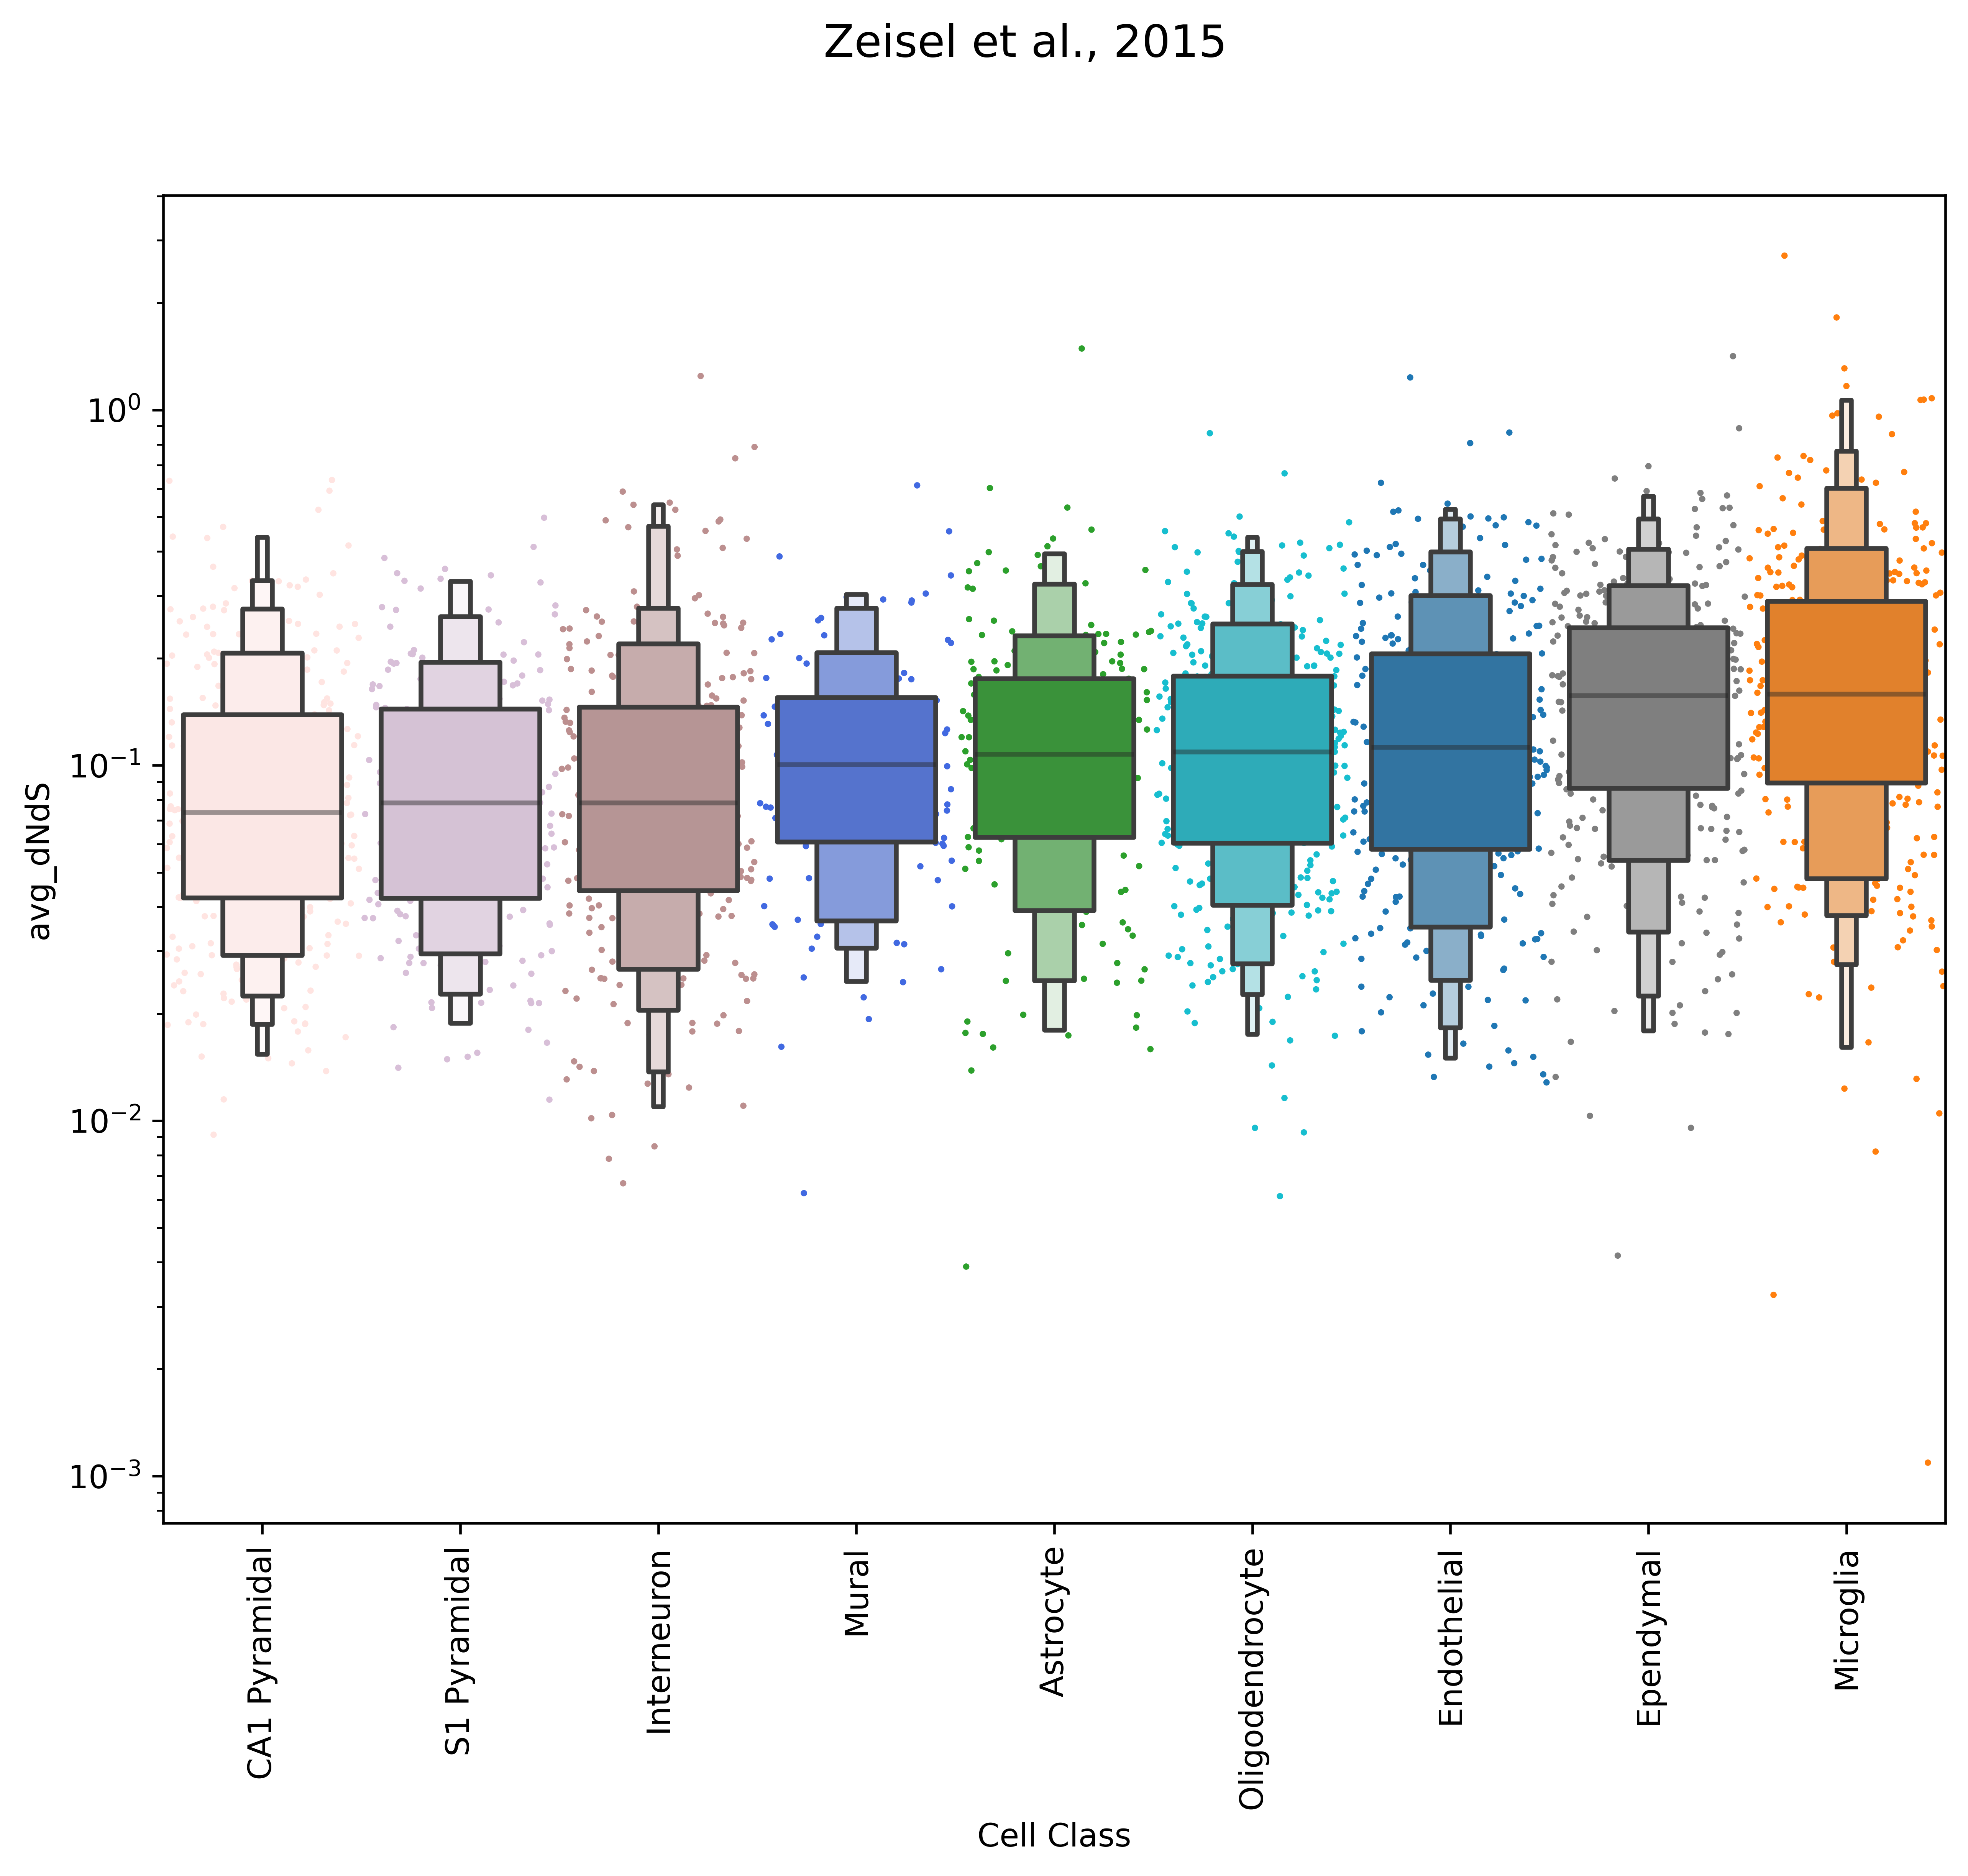

<Figure size 3840x2880 with 0 Axes>

In [83]:
# Creating a figure 
fig = plt.figure(figsize=(10,7.5)) # Size of a letter size paper in horizontal
title = fig.suptitle('Zeisel et al., 2015', fontsize=14)

# Setting subplot space
grid = plt.GridSpec(nrows=1,ncols=1)
#grid.update(wspace=0.5, hspace=0.3)

# The subplot for distribution histogram 
ax = fig.add_subplot(grid[:,:])
ax.set_yscale('log')

# Order from low to high median dN/dS
order=['CA1 Pyramidal', 'S1 Pyramidal', 'Interneuron', 'Mural', 'Astrocyte', 'Oligodendrocyte', 'Endothelial', 'Ependymal', 'Microglia']

# strip plot
# zorder put the dots behind fuure boxen plot
strip_plot = sns.stripplot(ax=ax,x='Cell Class',y='avg_dNdS',order=order,data=df,
                           palette=color_dict,size=2,dodge=True,jitter=0.49,zorder=0)
# swarm_plot = sns.swarmplot(ax=dot_plot,x='Cell Class',y='avg_dNdS',data=df,palette=color_dict,order=['CA1 Pyramidal', 'S1 Pyramidal', 'Interneuron', 'Mural', 'Astrocyte', 'Oligodendrocyte', 'Endothelial', 'Ependymal', 'Microglia'],size=5,dodge=True)

# enhanced box plot
# Tukey method says if a value is more than 1.5 times the interquartile range
# from the quartiles, they are outliers. 
boxen_plot = sns.boxenplot(ax=ax, x='Cell Class', y='avg_dNdS',order=order,data=df,
                           palette=color_dict,showfliers=False,k_depth='tukey')

plt.xticks(rotation=90)
plt.show()
plt.savefig('../figures/Distribution_Plots/dot_plot.zeisel_et_al_2015.svg')

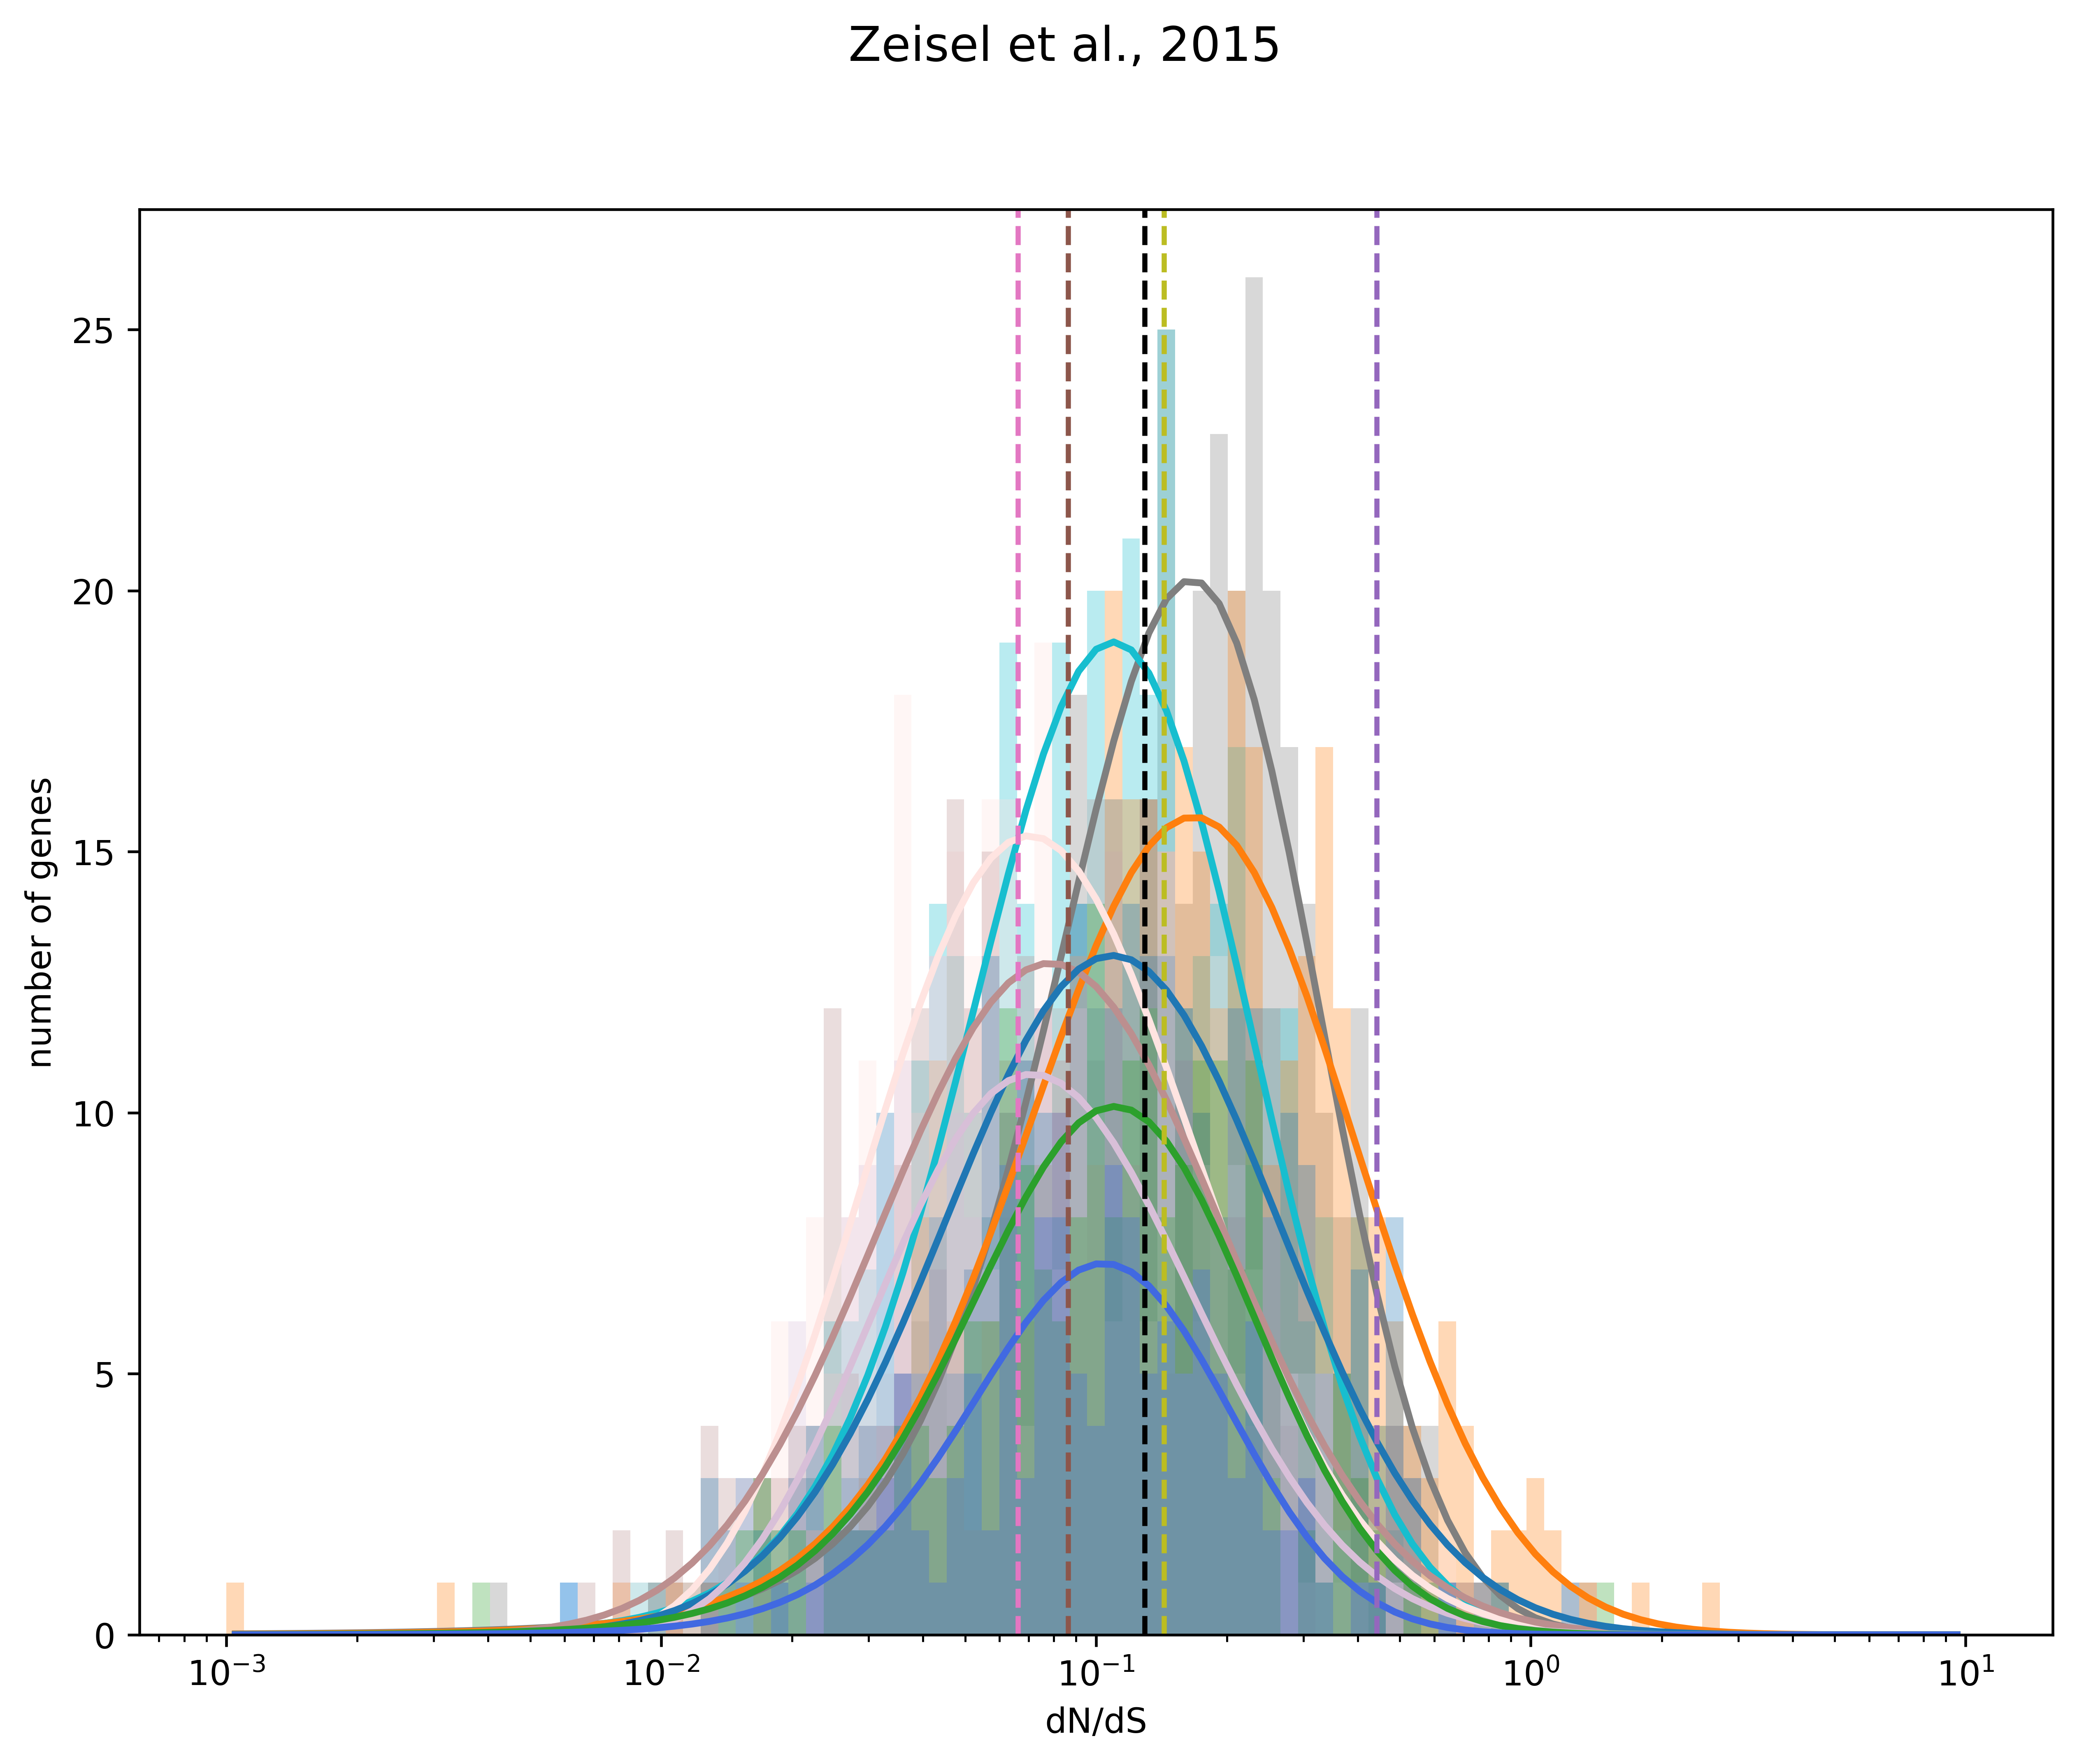

In [58]:
# Creating a figure 
fig = plt.figure(figsize=(10,7.5)) # Size of a letter size paper in horizontal
title = fig.suptitle('Zeisel et al., 2015', fontsize=14)

# Setting subplot space
grid = plt.GridSpec(nrows=1,ncols=1)
#grid.update(wspace=0.5, hspace=0.3)

# The subplot for distribution histogram 
distr_plot = fig.add_subplot(grid[:,:])

# Set up the bins for log scale x-axis, and get the centers
bins=np.logspace(np.log10(0.001),np.log10(10), 100)
bins_cntr = (bins[1:] + bins[:-1]) / 2



for celltype in df['Cell Class'].unique():
    arr=df[df['Cell Class']==celltype]['avg_dNdS'].to_numpy()
    counts, bin_edges, ignored = distr_plot.hist(arr,bins,histtype='stepfilled',alpha=0.3,color=color_dict[celltype],label='dN/dS of '+celltype+'-specific genes (med={0:.3f})'.format(np.median(arr)))
    try:
        # calculate area of histograms (area under PDF should be 1)
        area_hist = ((bin_edges[1:] - bin_edges[:-1]) * counts).sum()
        shape, loc, scale = stats.lognorm.fit(arr)
        # pdf-values using cdf 
        fit_log_cntr_ = stats.lognorm.cdf(bins, shape, loc=loc, scale=scale)
        fit_log_cntr = np.diff(fit_log_cntr_)
        # plot fitted and scaled PDFs into histogram
        _ = distr_plot.plot(bins_cntr, fit_log_cntr * counts.sum(),color=color_dict[celltype],linestyle='solid', 
                        label='lognormal fit of '+celltype+'-specific dN/dS distribution', linewidth=2)
    except ValueError:
        pass

# Benchmarks
for bm,dNdS in bm_dict.items():
    bm_line = distr_plot.axvline(dNdS,color=color_dict[bm],ls='--')

# distr_plot.axvline(np.median(mhc_arr),color='thistle',ls='--')
# distr_plot.axvline(np.median(atpase_arr),color='darkred',ls='--')
# distr_plot.axvline(np.median(n_arr),color='royalblue',ls='--')
# distr_plot.axvline(np.median(dnds_arr),color='gray',ls='--')
# Axis labels
x_label = distr_plot.set_xlabel(xlabel='dN/dS')
y_label = distr_plot.set_ylabel(ylabel='number of genes')
distr_plot.set_xscale('log')
plt.savefig('../figures/Distribution_Plots/zeisel_et_al_2015.svg')

# Three Cell Types: Neuron, Capillary, Glia (NCG)

Merging the nine cell types to be comparable to endothelia vs glia vs neuron plot from Barres data 

In [84]:
celltype_dict={
    'CA1 Pyramidal':'Neuron',
    'Interneuron':'Neuron',
    'S1 Pyramidal':'Neuron',
    'Oligodendrocyte':'Glia', 
    'Astrocyte':'Glia', 
    'Microglia':'Glia',
    'Ependymal':'Glia', 
    'Endothelial':'Capillary',
    'Mural':'Capillary',
}

In [86]:
df['NCG']=df['Cell Class'].map(celltype_dict)

In [87]:
df

Cell Class  avg_dNdS        NCG
Gene                                         
1110017D15Rik  Ependymal  0.250637       Glia
1700001O22Rik  Ependymal  0.530832       Glia
1700003E16Rik  Ependymal  0.361321       Glia
1700007K13Rik  Ependymal  0.215250       Glia
1700013F07Rik  Ependymal  0.433112       Glia
...                  ...       ...        ...
Whrn               Mural  0.082454  Capillary
Wnt5b              Mural  0.030886  Capillary
Wtip               Mural  0.105162  Capillary
Zbtb10             Mural  0.195299  Capillary
Zc2hc1a            Mural  0.112866  Capillary

[2718 rows x 3 columns]

In [92]:
three_type = [] # list of dictionaries to append to be dataframe
for celltype in df['NCG'].unique():
    dNdS_arr = df[df['NCG']==celltype]['avg_dNdS']
    median_dNdS = dNdS_arr.median()
    n=dNdS_arr.shape[0]
    low,high = stats.binom.interval(confidence=.95,n=dNdS_arr.shape[0],p=.5)
    CI_low = heapq.nsmallest(low.astype(int),dNdS_arr)[-1]
    CI_high = heapq.nsmallest(high.astype(int),dNdS_arr)[-1]
    string = f'{median_dNdS:.3f} ({CI_low:.3f}-{CI_high:.3f})'
    three_type.append(
        {
            'NCG Cell Class':celltype,
            'Median dN/dS (CI95%)':string,
            'Median dN/dS':median_dNdS
        })
three_type_df = pd.DataFrame(three_type)
three_type_df = three_type_df.sort_values(by=['Median dN/dS'])
three_type_df.drop(['Median dN/dS'],axis=1,inplace=True)

In [94]:
three_type_df

NCG Cell Class Median dN/dS (CI95%)
1         Neuron  0.076 (0.071-0.082)
2      Capillary  0.108 (0.099-0.117)
0           Glia  0.133 (0.126-0.140)

In [95]:
three_type_df.to_excel('../results/single-cell/zeisel_2015/three_type_median_dNdS_CI95.xlsx',index=False)

Neuron vs. Capillary: Mann-Whitney-Wilcoxon test two-sided, P_val:1.743e-09 U_stat=1.594e+05
Capillary vs. Glia: Mann-Whitney-Wilcoxon test two-sided, P_val:8.148e-05 U_stat=2.690e+05
Neuron vs. Glia: Mann-Whitney-Wilcoxon test two-sided, P_val:1.711e-37 U_stat=4.207e+05


(array([0, 1, 2]),
 [Text(0, 0, 'Neuron'), Text(1, 0, 'Capillary'), Text(2, 0, 'Glia')])

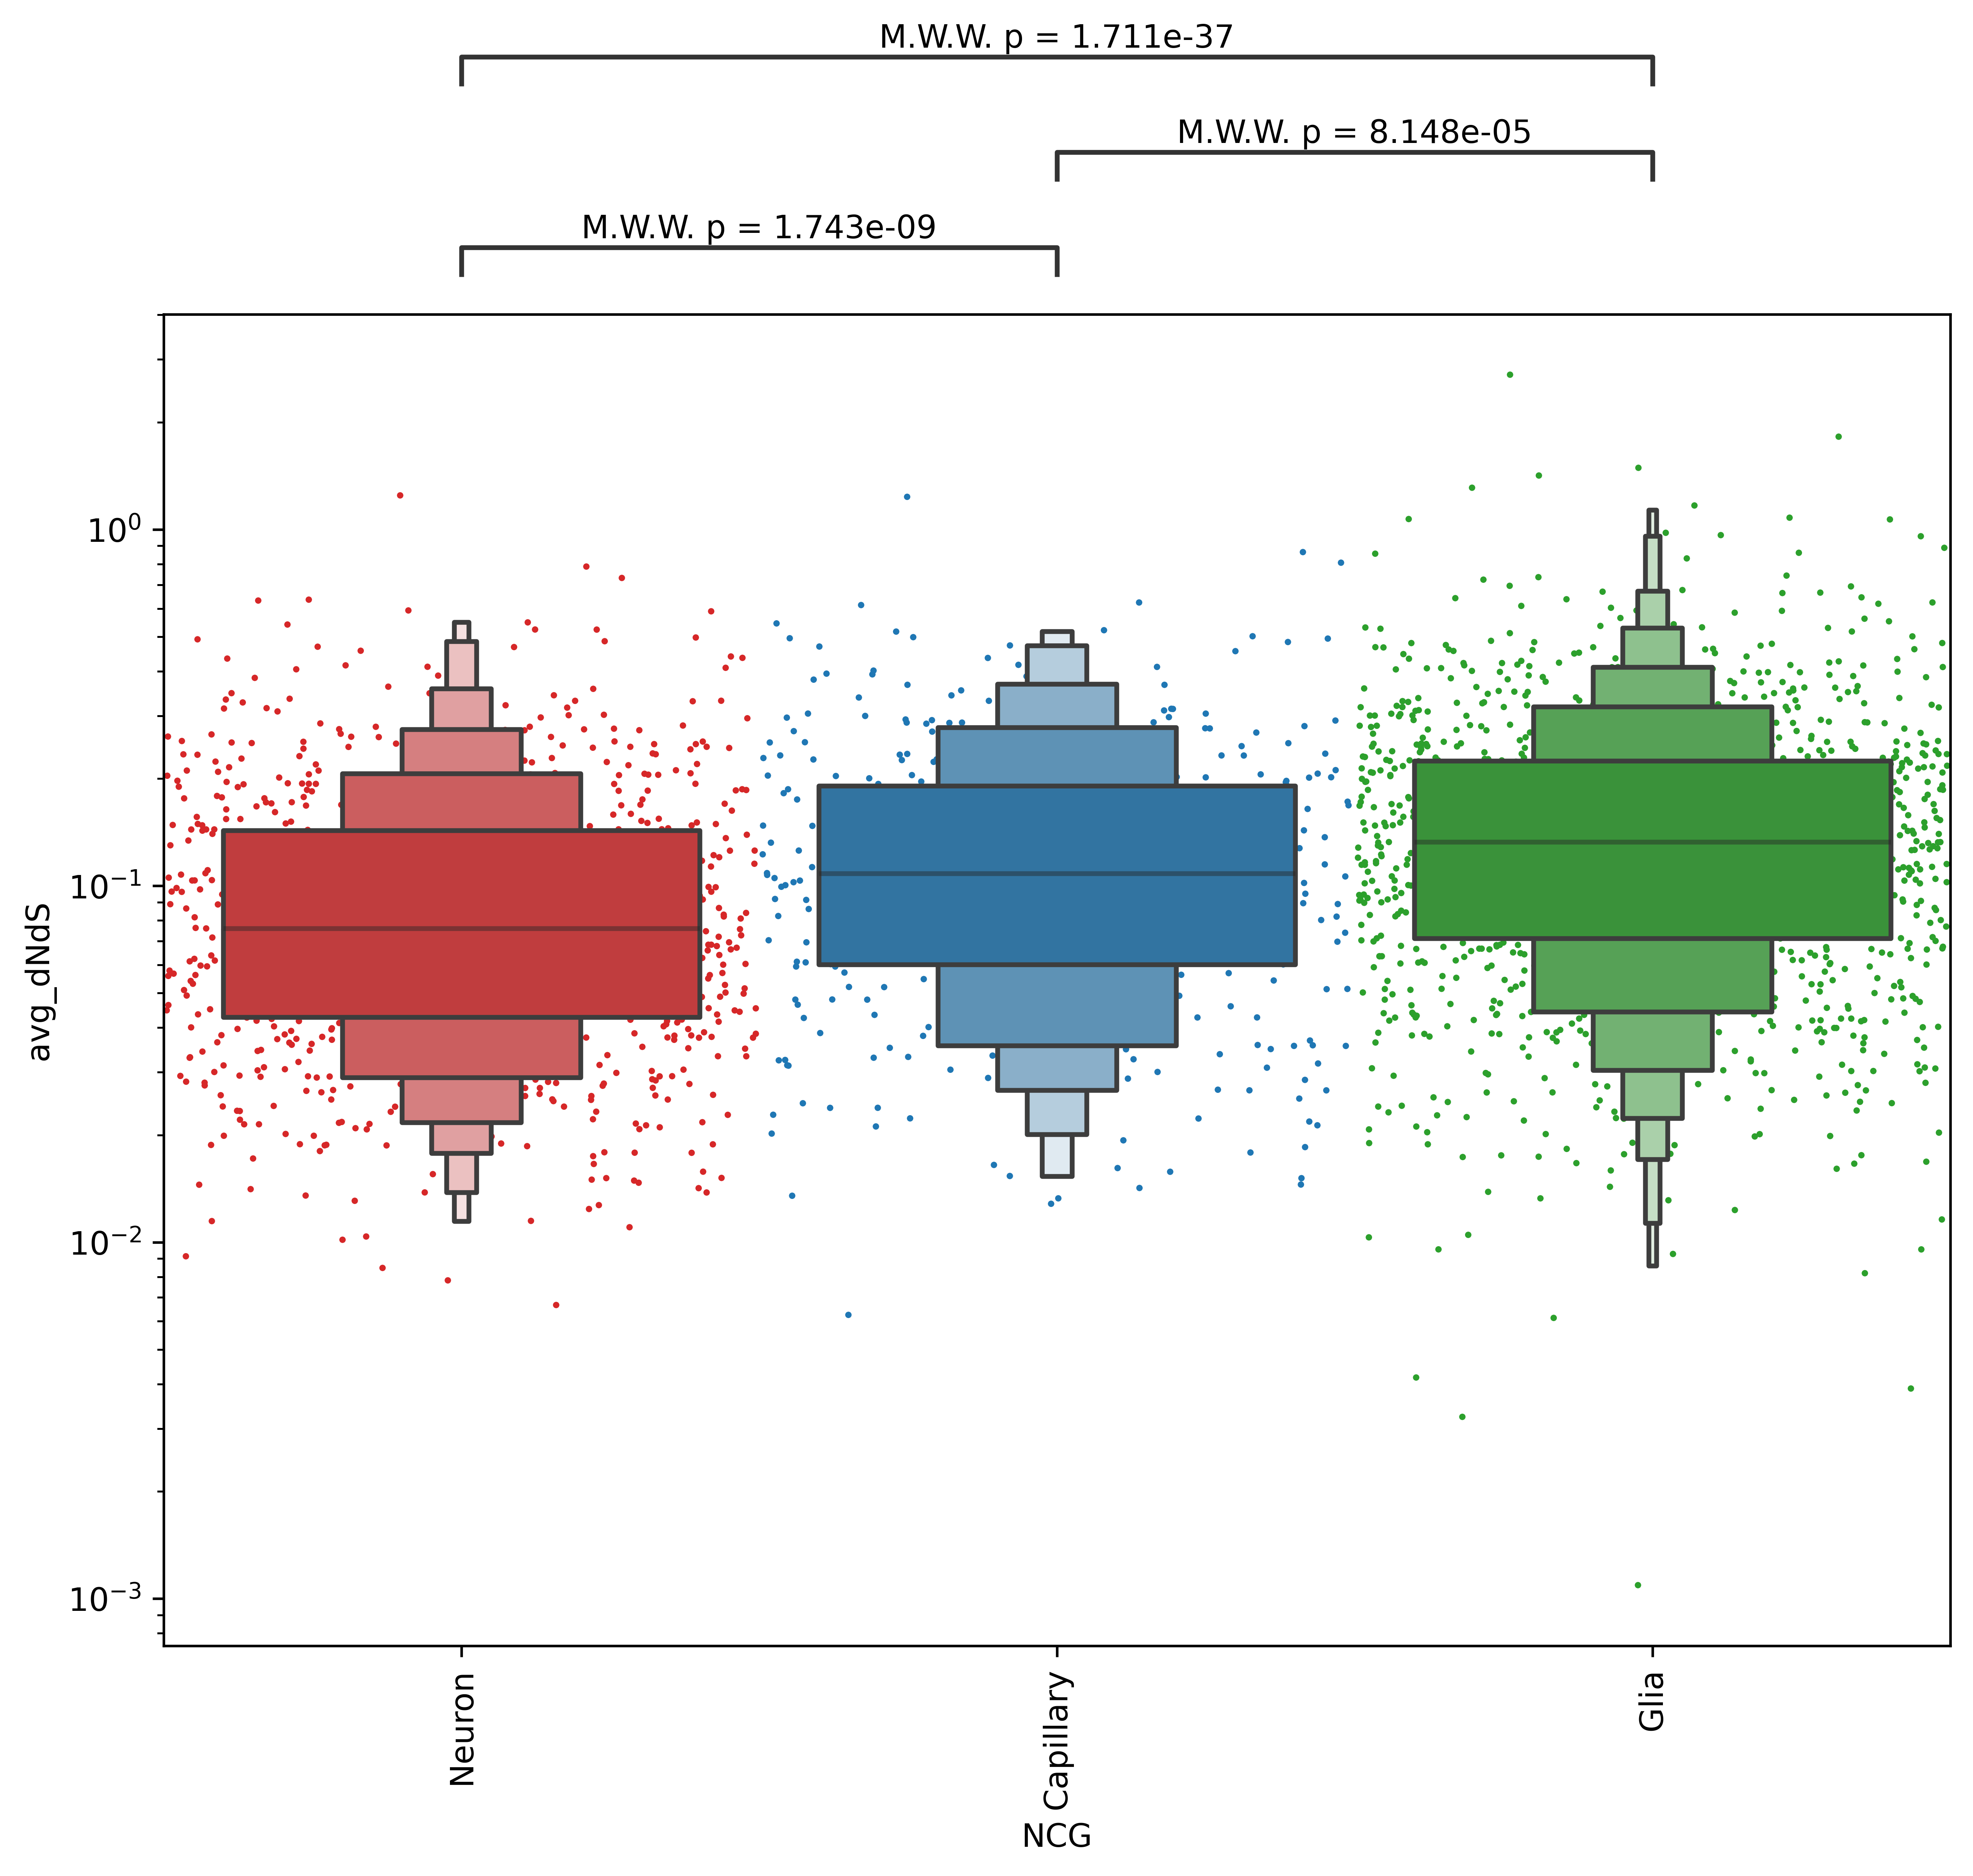

<Figure size 3840x2880 with 0 Axes>

In [109]:
# Creating a figure 
fig = plt.figure(figsize=(10,7.5)) # Size of a letter size paper in horizontal
# title = fig.suptitle('NCG Zeisel et al., 2015', fontsize=14)

# Setting subplot space
grid = plt.GridSpec(nrows=1,ncols=1)
#grid.update(wspace=0.5, hspace=0.3)

# The subplot for distribution histogram 
ax = fig.add_subplot(grid[:,:])
ax.set_yscale('log')

# Order from low to high median dN/dS
order=['Neuron','Capillary','Glia']

# strip plot
# zorder put the dots behind fuure boxen plot
# jitter=0.49 means no space between categories: imitating JMP-generated figures
strip_plot = sns.stripplot(ax=ax,x='NCG',y='avg_dNdS',order=order,data=df,
                           palette=color_dict,size=2,dodge=True,jitter=0.495,zorder=0)
# swarm_plot = sns.swarmplot(ax=dot_plot,x='Cell Class',y='avg_dNdS',data=df,palette=color_dict,order=['CA1 Pyramidal', 'S1 Pyramidal', 'Interneuron', 'Mural', 'Astrocyte', 'Oligodendrocyte', 'Endothelial', 'Ependymal', 'Microglia'],size=5,dodge=True)

# enhanced box plot
# Tukey method says if a value is more than 1.5 times the interquartile range
# from the quartiles, they are outliers. 
boxen_plot = sns.boxenplot(ax=ax, x='NCG', y='avg_dNdS',order=order,data=df,
                           palette=color_dict,showfliers=False,k_depth='tukey')

# Annotation with MWU significance 
box_pairs=[('Neuron','Capillary'),('Capillary','Glia'),('Neuron','Glia')]
order=['Neuron','Capillary','Glia']
annotation=Annotator(ax=ax,pairs=box_pairs,data=df,x='NCG', y='avg_dNdS',order=order)
annotation.configure(test='Mann-Whitney', text_format='full',
                     comparisons_correction=None,loc='outside',verbose=2)
annotation.apply_test()
ax, test_results = annotation.annotate()

plt.xticks(rotation=90)
# plt.autoscale()
plt.show()
plt.savefig('../figures/Distribution_Plots/dot_plot.NCG.zeisel_et_al_2015.svg')

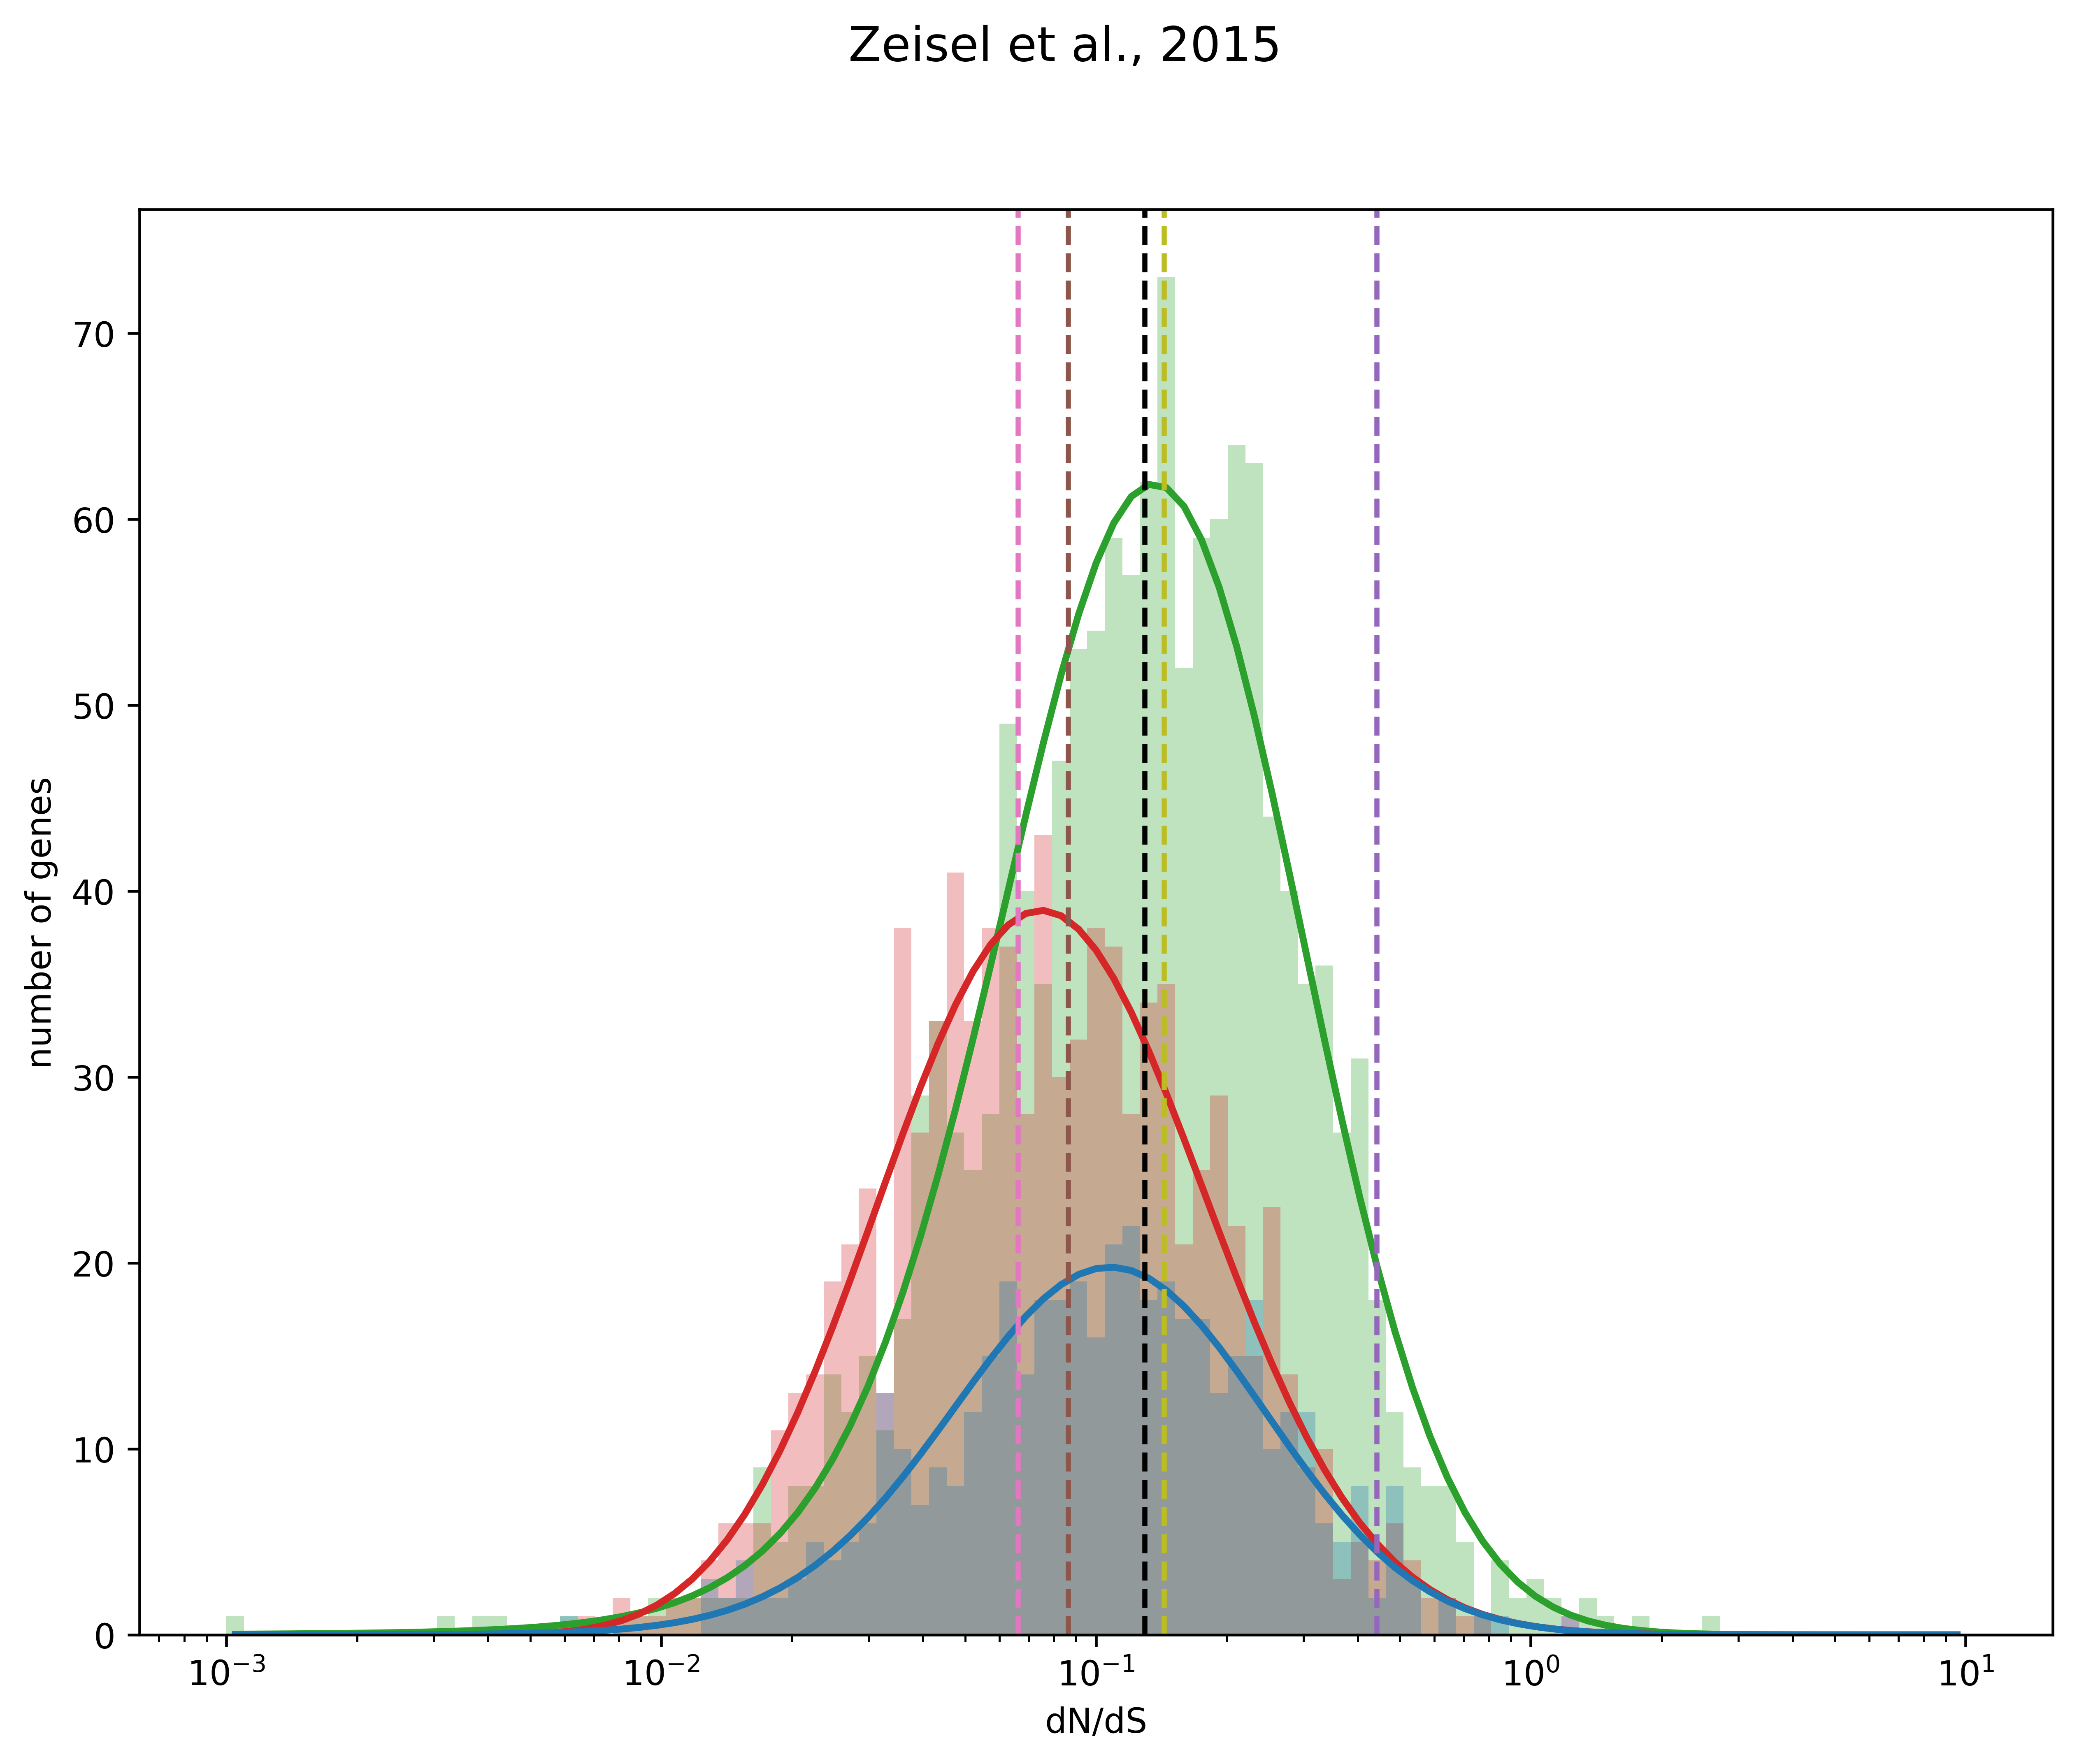

In [111]:
# Creating a figure 
fig = plt.figure(figsize=(10,7.5)) # Size of a letter size paper in horizontal
title = fig.suptitle('Zeisel et al., 2015', fontsize=14)

# Setting subplot space
grid = plt.GridSpec(nrows=1,ncols=1)
#grid.update(wspace=0.5, hspace=0.3)

# The subplot for distribution histogram 
distr_plot = fig.add_subplot(grid[:,:])

# Set up the bins for log scale x-axis, and get the centers
bins=np.logspace(np.log10(0.001),np.log10(10), 100)
bins_cntr = (bins[1:] + bins[:-1]) / 2

for celltype in df['NCG'].unique():
    arr=df[df['NCG']==celltype]['avg_dNdS'].to_numpy()
    counts, bin_edges, ignored = distr_plot.hist(arr,bins,histtype='stepfilled',alpha=0.3,color=color_dict[celltype],label='dN/dS of '+celltype+'-specific genes (med={0:.3f})'.format(np.median(arr)))
    try:
        # calculate area of histograms (area under PDF should be 1)
        area_hist = ((bin_edges[1:] - bin_edges[:-1]) * counts).sum()
        shape, loc, scale = stats.lognorm.fit(arr)
        # pdf-values using cdf 
        fit_log_cntr_ = stats.lognorm.cdf(bins, shape, loc=loc, scale=scale)
        fit_log_cntr = np.diff(fit_log_cntr_)
        # plot fitted and scaled PDFs into histogram
        _ = distr_plot.plot(bins_cntr, fit_log_cntr * counts.sum(),color=color_dict[celltype],linestyle='solid', 
                        label='lognormal fit of '+celltype+'-specific dN/dS distribution', linewidth=2)
    except ValueError:
        pass

# Benchmarks
for bm,dNdS in bm_dict.items():
    bm_line = distr_plot.axvline(dNdS,color=color_dict[bm],ls='--')

# distr_plot.axvline(np.median(mhc_arr),color='thistle',ls='--')
# distr_plot.axvline(np.median(atpase_arr),color='darkred',ls='--')
# distr_plot.axvline(np.median(n_arr),color='royalblue',ls='--')
# distr_plot.axvline(np.median(dnds_arr),color='gray',ls='--')
# Axis labels
x_label = distr_plot.set_xlabel(xlabel='dN/dS')
y_label = distr_plot.set_ylabel(ylabel='number of genes')
distr_plot.set_xscale('log')
plt.savefig('../figures/Distribution_Plots/NCG.zeisel_et_al_2015.svg')

# Five types: NEAMO

In [113]:
NEAMO_dict={
    'CA1 Pyramidal':'Neuron',
    'Interneuron':'Neuron',
    'S1 Pyramidal':'Neuron',
    'Oligodendrocyte':'Oligodendrocyte', 
    'Astrocyte':'Astrocyte', 
    'Microglia':'Microglia',
    'Ependymal':np.nan, 
    'Endothelial':'Endothelial',
    'Mural':np.nan,
}

In [114]:
df['NEAMO']=df['Cell Class'].map(NEAMO_dict)

In [128]:
df['NEAMO'].dropna().unique()

array(['Oligodendrocyte', 'Microglia', 'Neuron', 'Endothelial',
       'Astrocyte'], dtype=object)

In [129]:
# Median, confidence interval
NEAMO_type = [] # list of dictionaries to append to be dataframe
for celltype in df['NEAMO'].dropna().unique():
    dNdS_arr = df[df['NEAMO']==celltype]['avg_dNdS']
    median_dNdS = dNdS_arr.median()
    n=dNdS_arr.shape[0]
    low,high = stats.binom.interval(confidence=.95,n=dNdS_arr.shape[0],p=.5)
    CI_low = heapq.nsmallest(low.astype(int),dNdS_arr)[-1]
    CI_high = heapq.nsmallest(high.astype(int),dNdS_arr)[-1]
    string = f'{median_dNdS:.3f} ({CI_low:.3f}-{CI_high:.3f})'
    NEAMO_type.append(
        {
            'NEAMO Cell Class':celltype,
            'Median dN/dS (CI95%)':string,
            'Median dN/dS':median_dNdS
        })
NEAMO_type_df = pd.DataFrame(NEAMO_type)
NEAMO_type_df = NEAMO_type_df.sort_values(by=['Median dN/dS'])
NEAMO_type_df.drop(['Median dN/dS'],axis=1,inplace=True)

In [130]:
NEAMO_type_df

NEAMO Cell Class Median dN/dS (CI95%)
2           Neuron  0.076 (0.071-0.082)
4        Astrocyte  0.108 (0.096-0.124)
0  Oligodendrocyte  0.109 (0.098-0.118)
3      Endothelial  0.113 (0.099-0.128)
1        Microglia  0.159 (0.139-0.174)

In [131]:
NEAMO_type_df.to_excel('../results/single-cell/zeisel_2015/NEAMO_median_dNdS_CI95.xlsx',index=False)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Neuron'),
  Text(1, 0, 'Astrocyte'),
  Text(2, 0, 'Oligodendrocyte'),
  Text(3, 0, 'Endothelial'),
  Text(4, 0, 'Microglia')])

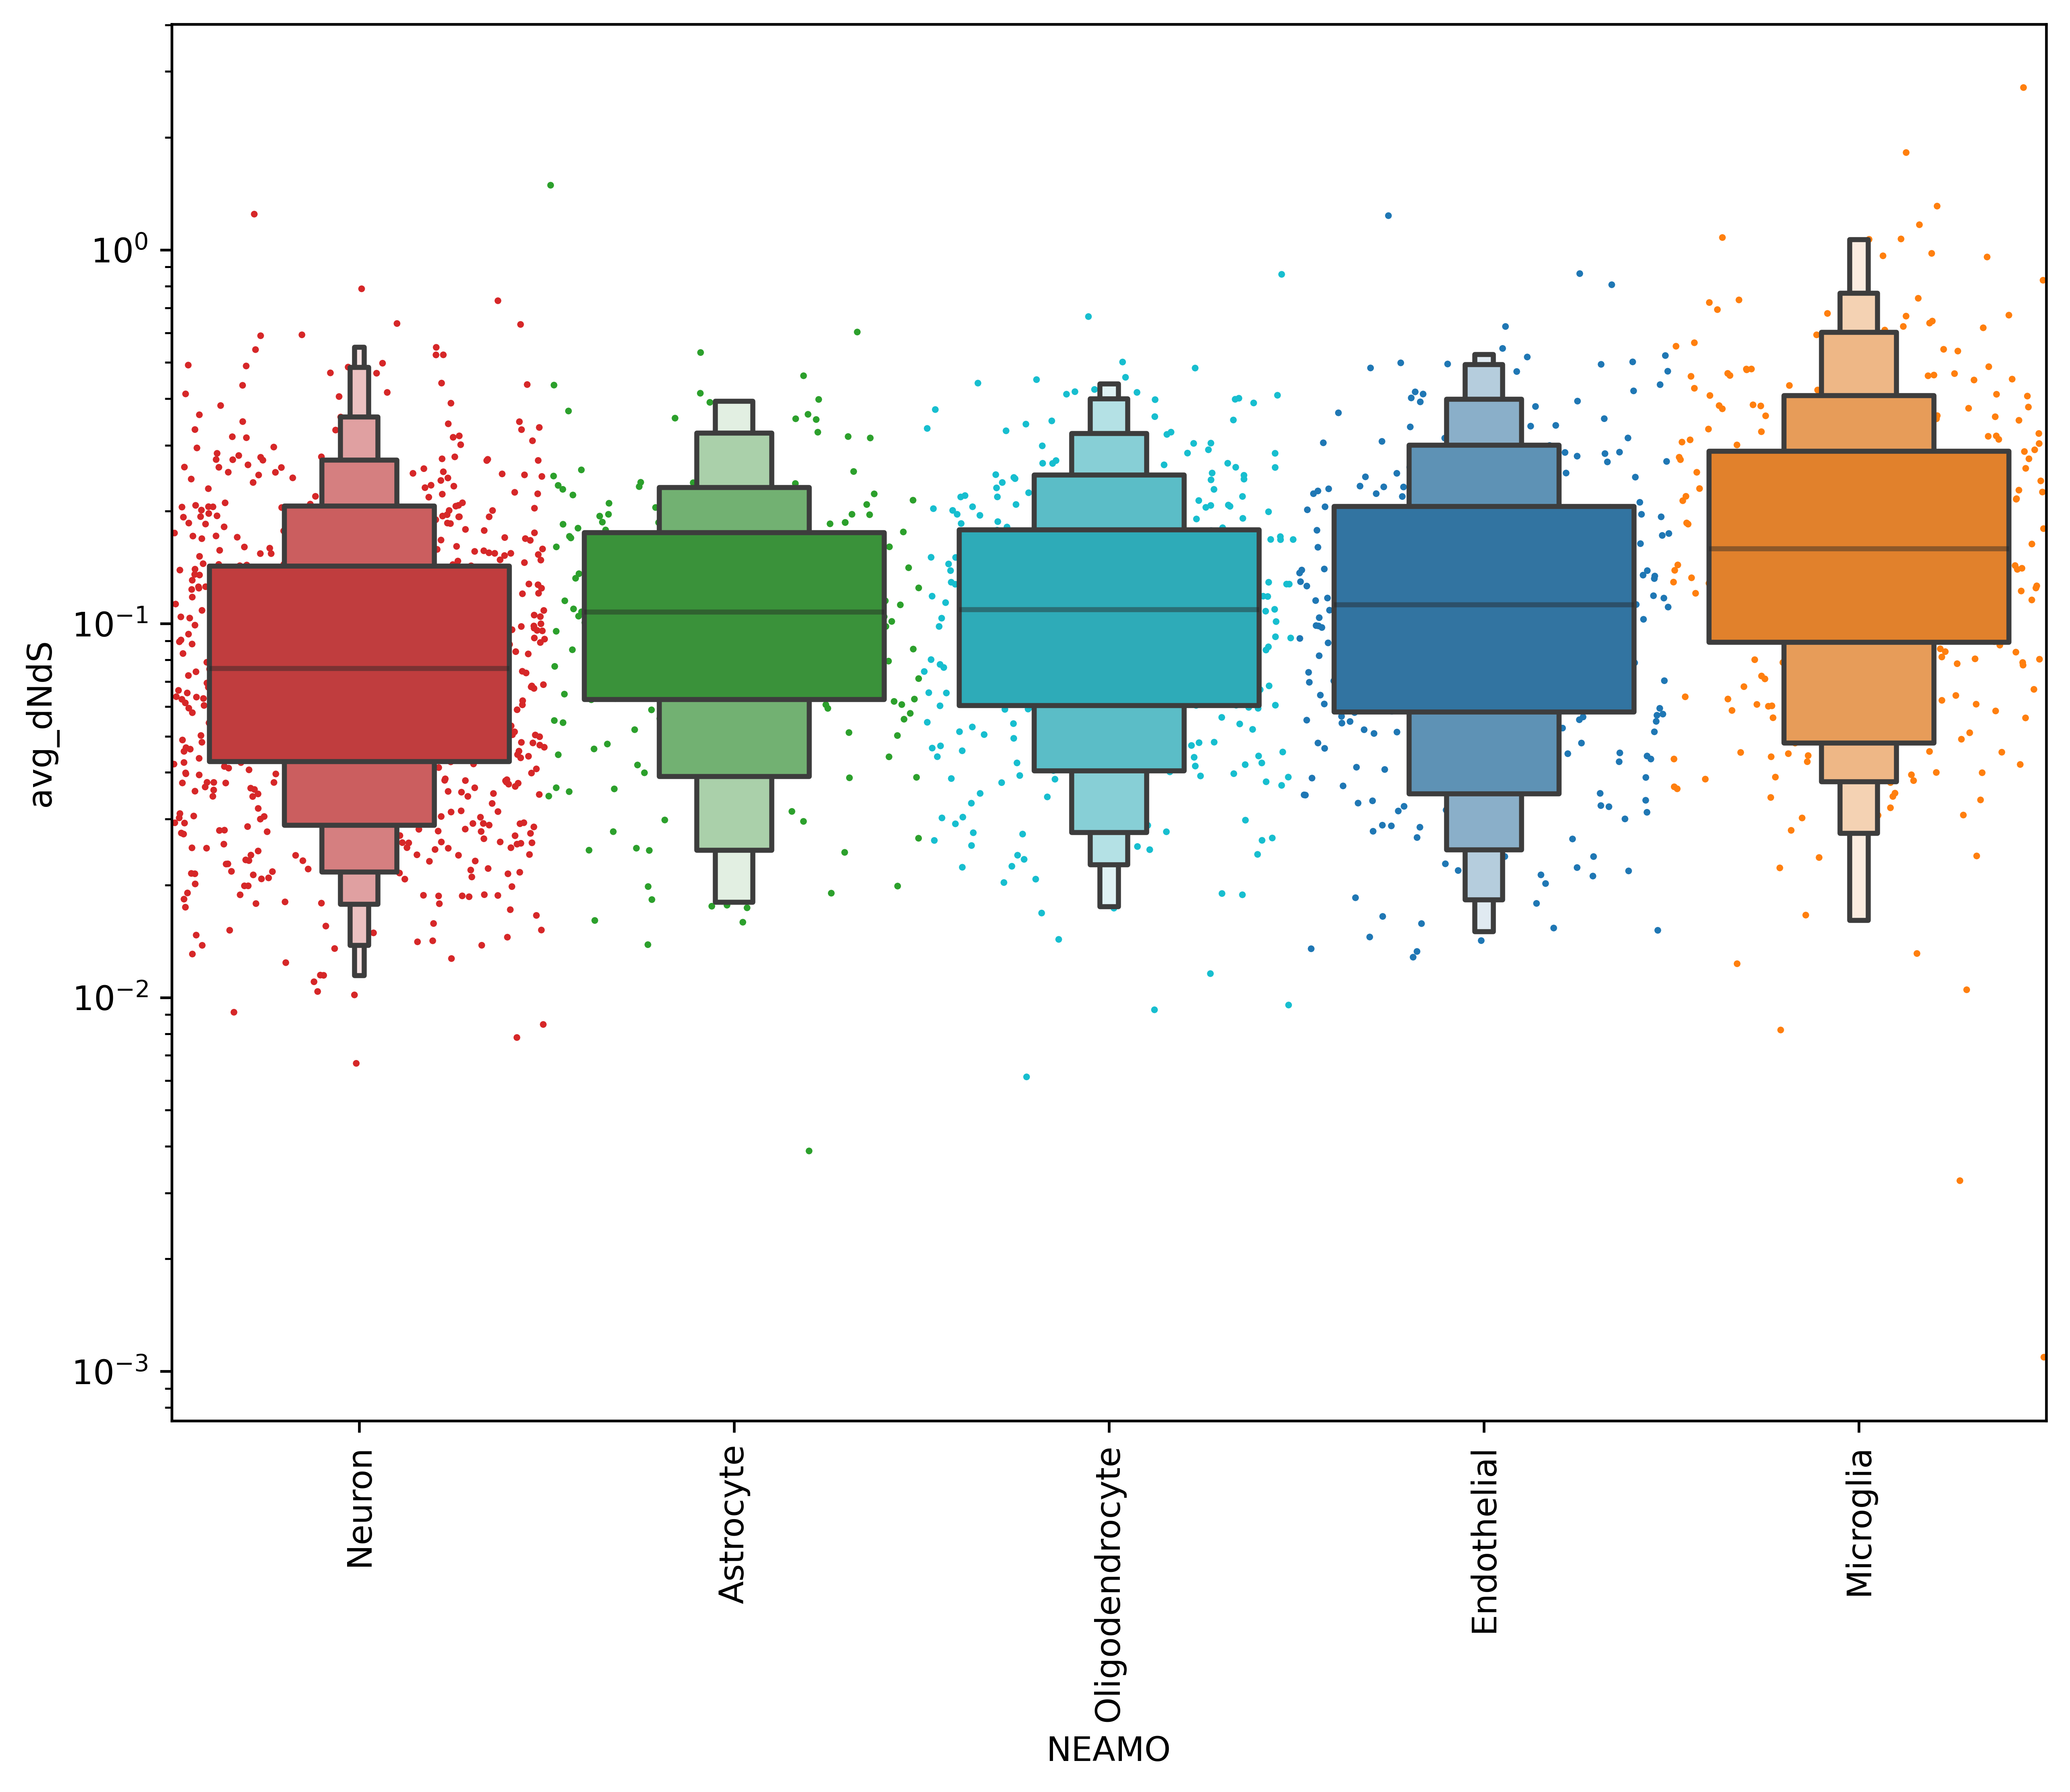

<Figure size 3840x2880 with 0 Axes>

In [133]:
# Creating a figure 
fig = plt.figure(figsize=(10,7.5)) # Size of a letter size paper in horizontal
# title = fig.suptitle('NEAMO Zeisel et al., 2015', fontsize=14)

# Setting subplot space
grid = plt.GridSpec(nrows=1,ncols=1)
#grid.update(wspace=0.5, hspace=0.3)

# The subplot for distribution histogram 
ax = fig.add_subplot(grid[:,:])
ax.set_yscale('log')

# Order from low to high median dN/dS
order=['Neuron','Astrocyte','Oligodendrocyte','Endothelial','Microglia']# NAOEM

# strip plot
# zorder put the dots behind fuure boxen plot
# jitter=0.49 means no space between categories: imitating JMP-generated figures
strip_plot = sns.stripplot(ax=ax,x='NEAMO',y='avg_dNdS',order=order,data=df,
                           palette=color_dict,size=2,dodge=True,jitter=0.495,zorder=0)
# swarm_plot = sns.swarmplot(ax=dot_plot,x='Cell Class',y='avg_dNdS',data=df,palette=color_dict,order=['CA1 Pyramidal', 'S1 Pyramidal', 'Interneuron', 'Mural', 'Astrocyte', 'Oligodendrocyte', 'Endothelial', 'Ependymal', 'Microglia'],size=5,dodge=True)

# enhanced box plot
# Tukey method says if a value is more than 1.5 times the interquartile range
# from the quartiles, they are outliers. 
boxen_plot = sns.boxenplot(ax=ax, x='NEAMO', y='avg_dNdS',order=order,data=df,
                           palette=color_dict,showfliers=False,k_depth='tukey')

# # Annotation with MWU significance 
# box_pairs=[('Neuron','Capillary'),('Capillary','Glia'),('Neuron','Glia')]
# order=['Neuron','Capillary','Glia']
# annotation=Annotator(ax=ax,pairs=box_pairs,data=df,x='NEAMO', y='avg_dNdS',order=order)
# annotation.configure(test='Mann-Whitney', text_format='full',
#                      comparisons_correction=None,loc='outside',verbose=2)
# annotation.apply_test()
# ax, test_results = annotation.annotate()

plt.xticks(rotation=90)
# plt.autoscale()
plt.show()
plt.savefig('../figures/Distribution_Plots/dot_plot.NEAMO.zeisel_et_al_2015.svg')

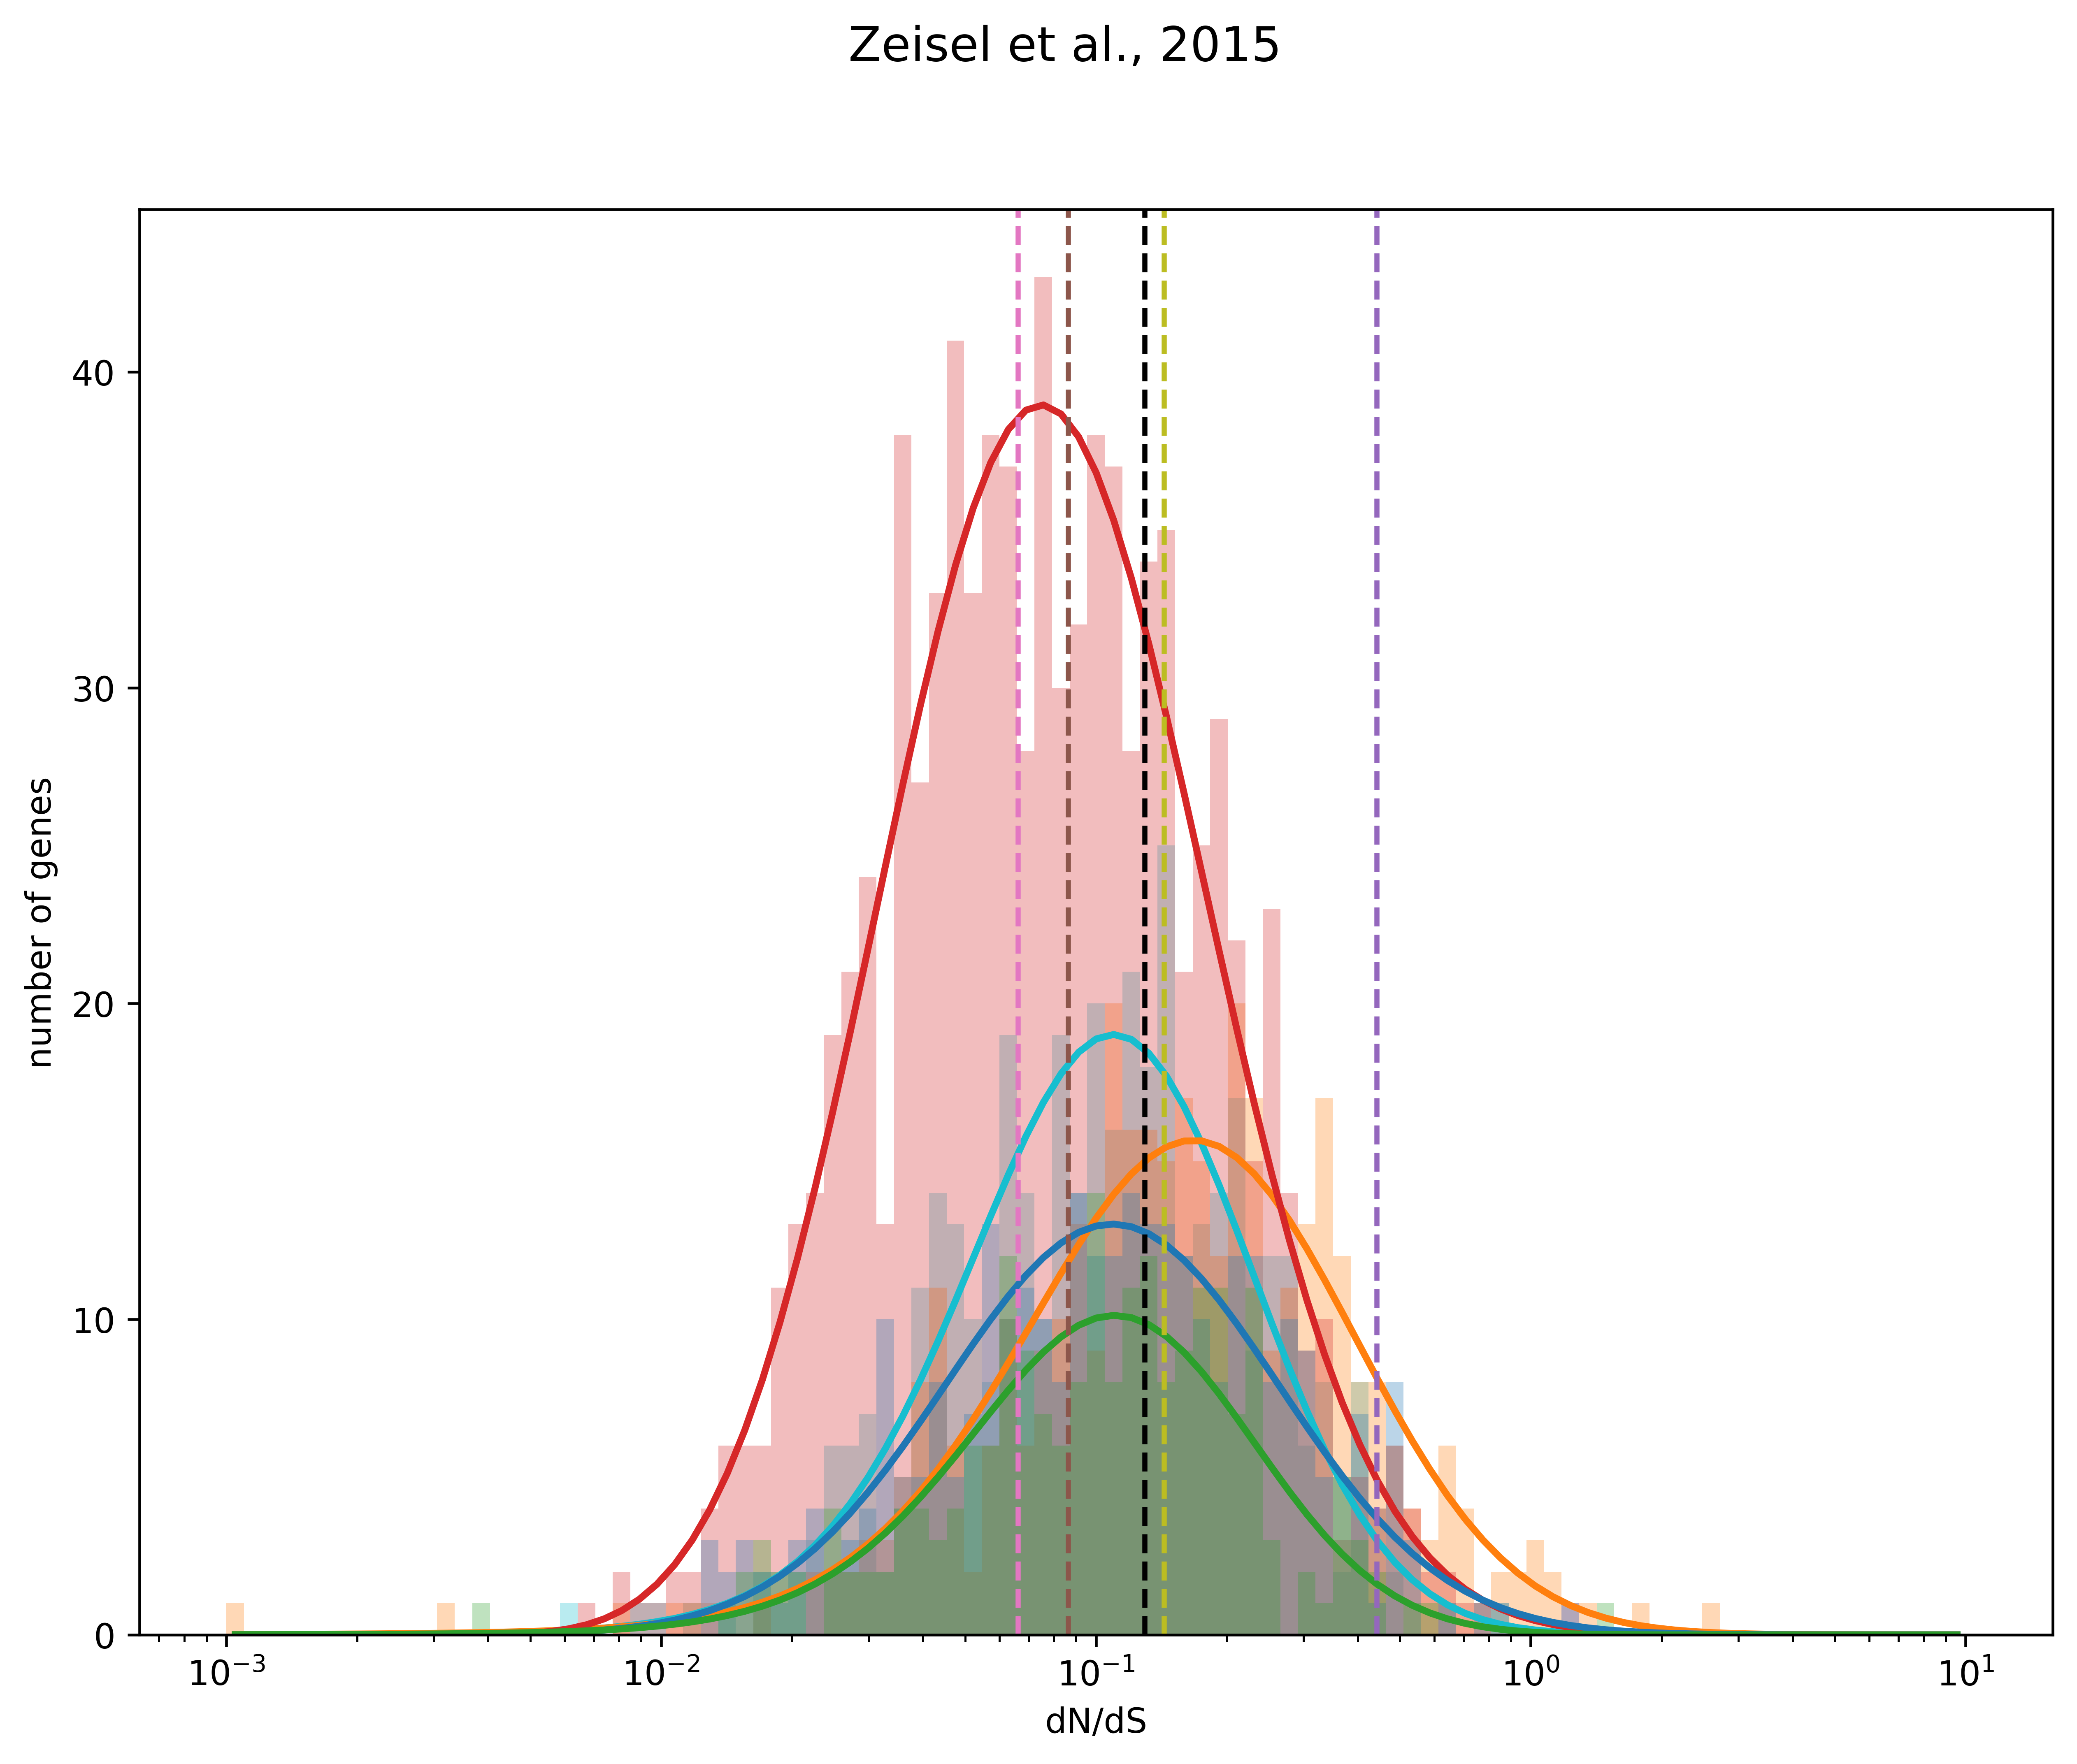

In [135]:
# Creating a figure 
fig = plt.figure(figsize=(10,7.5)) # Size of a letter size paper in horizontal
title = fig.suptitle('Zeisel et al., 2015', fontsize=14)

# Setting subplot space
grid = plt.GridSpec(nrows=1,ncols=1)
#grid.update(wspace=0.5, hspace=0.3)

# The subplot for distribution histogram 
distr_plot = fig.add_subplot(grid[:,:])

# Set up the bins for log scale x-axis, and get the centers
bins=np.logspace(np.log10(0.001),np.log10(10), 100)
bins_cntr = (bins[1:] + bins[:-1]) / 2

for celltype in df['NEAMO'].dropna().unique():
    arr=df[df['NEAMO']==celltype]['avg_dNdS'].to_numpy()
    counts, bin_edges, ignored = distr_plot.hist(arr,bins,histtype='stepfilled',alpha=0.3,color=color_dict[celltype],label='dN/dS of '+celltype+'-specific genes (med={0:.3f})'.format(np.median(arr)))
    try:
        # calculate area of histograms (area under PDF should be 1)
        area_hist = ((bin_edges[1:] - bin_edges[:-1]) * counts).sum()
        shape, loc, scale = stats.lognorm.fit(arr)
        # pdf-values using cdf 
        fit_log_cntr_ = stats.lognorm.cdf(bins, shape, loc=loc, scale=scale)
        fit_log_cntr = np.diff(fit_log_cntr_)
        # plot fitted and scaled PDFs into histogram
        _ = distr_plot.plot(bins_cntr, fit_log_cntr * counts.sum(),color=color_dict[celltype],linestyle='solid',
                            label='lognormal fit of '+celltype+'-specific dN/dS distribution', linewidth=2)
    except ValueError:
        pass

# Benchmarks
for bm,dNdS in bm_dict.items():
    bm_line = distr_plot.axvline(dNdS,color=color_dict[bm],ls='--')

# distr_plot.axvline(np.median(mhc_arr),color='thistle',ls='--')
# distr_plot.axvline(np.median(atpase_arr),color='darkred',ls='--')
# distr_plot.axvline(np.median(n_arr),color='royalblue',ls='--')
# distr_plot.axvline(np.median(dnds_arr),color='gray',ls='--')
# Axis labels
x_label = distr_plot.set_xlabel(xlabel='dN/dS')
y_label = distr_plot.set_ylabel(ylabel='number of genes')
distr_plot.set_xscale('log')
plt.savefig('../figures/Distribution_Plots/NEAMO.zeisel_et_al_2015.svg')

# NCG pairwise dN/dS

In [174]:
pw_df['NCG']=df['Cell Class'].map(celltype_dict)

In [175]:
pw_df

Cell Class  amelanoleuca_dNdS  anancymaae_dNdS  bbbison_dNdS  \
1110017D15Rik  Ependymal           0.239019         0.306353      0.296007   
1700001O22Rik  Ependymal           0.520559              NaN           NaN   
1700003E16Rik  Ependymal           0.366365         0.368277      0.303517   
1700007K13Rik  Ependymal                NaN         0.192421           NaN   
1700013F07Rik  Ependymal                NaN         0.506895      0.305108   
...                  ...                ...              ...           ...   
Whrn               Mural           0.091038         0.111701           NaN   
Wnt5b              Mural           0.020163              NaN      0.020328   
Wtip               Mural                NaN         0.102421           NaN   
Zbtb10             Mural           0.207639              NaN      0.157405   
Zc2hc1a            Mural           0.117205         0.112397      0.106298   

               bmutus_dNdS  btaurus_dNdS  capalliatus_dNdS  caperea_dNdS  \
1110017D15Rik          NaN           NaN          0.283326      0.189394   
1700001O22Rik     0.403191      0.413631               NaN           NaN   
1700003E16Rik     0.373628      0.330666          0.346729      0.371554   
1700007K13Rik     0.199512      0.200678          0.173491      0.195014   
1700013F07Rik     0.313156      0.305108          0.547696           NaN   
...                    ...           ...               ...           ...   
Whrn              0.066147      0.069679          0.077770      0.088928   
Wnt5b                  NaN      0.019437               NaN           NaN   
Wtip                   NaN      0.098005               NaN           NaN   
Zbtb10                 NaN      0.183981          0.167976           NaN   
Zc2hc1a           0.106628      0.106628          0.120363      0.096759   

               catys_dNdS  ccanadensis_dNdS  ...  tbelangeri_dNdS  \
1110017D15Rik    0.265055          0.200961  ...              NaN   
1700001O22Rik    0.446168          0.437332  ...              NaN   
1700003E16Rik    0.501628               NaN  ...              NaN   
1700007K13Rik    0.191203          0.157401  ...         0.323685   
1700013F07Rik    0.503694          0.366558  ...              NaN   
...                   ...               ...  ...              ...   
Whrn             0.079087               NaN  ...              NaN   
Wnt5b            0.029170          0.030306  ...              NaN   
Wtip             0.087019          0.194408  ...              NaN   
Zbtb10           0.183628          0.204053  ...              NaN   
Zc2hc1a          0.109511          0.100712  ...              NaN   

               tgelada_dNdS  ttruncatus_dNdS  uamericanus_dNdS  \
1110017D15Rik      0.279674              NaN          0.221301   
1700001O22Rik      0.378076              NaN          0.485985   
1700003E16Rik      0.350282              NaN          0.352135   
1700007K13Rik      0.192011         0.182870          0.209988   
1700013F07Rik      0.504162              NaN               NaN   
...                     ...              ...               ...   
Whrn               0.080153         0.070822          0.107660   
Wnt5b              0.027702              NaN               NaN   
Wtip               0.083221              NaN               NaN   
Zbtb10             0.185678         0.165237          0.191200   
Zc2hc1a            0.102366              NaN          0.168186   

               umaritimus_dNdS  uparryii_dNdS  vpacos_dNdS  vursinus_dNdS  \
1110017D15Rik              NaN       0.241042     0.283537            NaN   
1700001O22Rik              NaN            NaN          NaN            NaN   
1700003E16Rik         0.364338            NaN          NaN       0.011474   
1700007K13Rik              NaN       0.134736          NaN       0.128650   
1700013F07Rik         0.351662       0.395551          NaN            NaN   
...                        ...            ...          ...            ...   
Whr

# Others

In [91]:
arr_dict={}
for celltype in df['Cell Class'].unique():
    arr=df[df['Cell Class']==celltype]['avg_dNdS'].to_numpy()
    arr_dict.update({celltype:arr})

In [92]:
pg.mwu(arr_dict['CA1 Pyramidal'],arr_dict['Mural'],alternative='two-sided')

U-val alternative     p-val       RBC     CLES
MWU  19280.0   two-sided  0.002933  0.174481  0.41276

In [107]:
pg.mwu(arr_dict['Interneuron'],arr_dict['Mural'],alternative='two-sided')

U-val alternative     p-val       RBC      CLES
MWU  18285.0   two-sided  0.021018  0.137297  0.431352

In [104]:
from itertools import combinations

### With 0.0001 strict threshold for p-value

In [120]:
for perm in combinations(['CA1 Pyramidal', 'S1 Pyramidal', 'Interneuron', 'Mural', 'Astrocyte', 'Oligodendrocyte', 'Endothelial', 'Ependymal', 'Microglia'],2):
    celltype1 = perm[0]
    celltype2 = perm[1]

    mwu_df = pg.mwu(arr_dict[celltype2],arr_dict[celltype1],alternative='two-sided')
    
    if mwu_df.loc['MWU','p-val'] < 0.0001:
        print('------------------')
        print(celltype1+' vs '+celltype2)
        mwu_df

------------------
CA1 Pyramidal vs Astrocyte


U-val alternative     p-val       RBC      CLES
MWU  43991.0   two-sided  0.000048 -0.205134  0.602567

------------------
CA1 Pyramidal vs Oligodendrocyte


U-val alternative         p-val       RBC      CLES
MWU  82188.0   two-sided  6.603787e-07 -0.211926  0.605963

------------------
CA1 Pyramidal vs Endothelial


U-val alternative         p-val       RBC      CLES
MWU  66357.0   two-sided  2.365859e-07 -0.233333  0.616666

------------------
CA1 Pyramidal vs Ependymal


U-val alternative         p-val       RBC      CLES
MWU  97488.0   two-sided  1.208884e-22 -0.415865  0.707933

------------------
CA1 Pyramidal vs Microglia


U-val alternative         p-val       RBC      CLES
MWU  93282.0   two-sided  6.469598e-24 -0.434049  0.717024

------------------
S1 Pyramidal vs Oligodendrocyte


U-val alternative     p-val       RBC      CLES
MWU  55411.0   two-sided  0.000021 -0.203018  0.601509

------------------
S1 Pyramidal vs Endothelial


U-val alternative     p-val       RBC      CLES
MWU  44859.0   two-sided  0.000005 -0.227584  0.613792

------------------
S1 Pyramidal vs Ependymal


U-val alternative         p-val       RBC      CLES
MWU  66300.0   two-sided  1.527188e-18 -0.417727  0.708863

------------------
S1 Pyramidal vs Microglia


U-val alternative         p-val       RBC      CLES
MWU  63356.0   two-sided  1.669733e-19 -0.434043  0.717021

------------------
Interneuron vs Oligodendrocyte


U-val alternative    p-val       RBC      CLES
MWU  72347.0   two-sided  0.00006 -0.175533  0.587766

------------------
Interneuron vs Endothelial


U-val alternative     p-val       RBC      CLES
MWU  58643.0   two-sided  0.000014 -0.201036  0.600518

------------------
Interneuron vs Ependymal


U-val alternative         p-val      RBC      CLES
MWU  86340.0   two-sided  2.064713e-18 -0.38175  0.690875

------------------
Interneuron vs Microglia


U-val alternative         p-val       RBC      CLES
MWU  82586.0   two-sided  1.665120e-19 -0.399004  0.699502

------------------
Mural vs Ependymal


U-val alternative         p-val      RBC     CLES
MWU  35047.0   two-sided  1.215947e-07 -0.30456  0.65228

------------------
Mural vs Microglia


U-val alternative         p-val       RBC      CLES
MWU  33574.0   two-sided  2.583428e-08 -0.322853  0.661426

------------------
Astrocyte vs Ependymal


U-val alternative         p-val       RBC      CLES
MWU  52784.0   two-sided  1.746179e-07 -0.257091  0.628546

------------------
Astrocyte vs Microglia


U-val alternative         p-val       RBC      CLES
MWU  50572.0   two-sided  3.200540e-08 -0.274882  0.637441

------------------
Oligodendrocyte vs Ependymal


U-val alternative         p-val       RBC      CLES
MWU  96926.0   two-sided  3.656162e-09 -0.242514  0.621257

------------------
Oligodendrocyte vs Microglia


U-val alternative         p-val       RBC      CLES
MWU  93334.0   two-sided  1.662719e-10 -0.266473  0.633237

------------------
Endothelial vs Ependymal


U-val alternative     p-val       RBC      CLES
MWU  73139.0   two-sided  0.000032 -0.181777  0.590889

------------------
Endothelial vs Microglia


U-val alternative     p-val       RBC      CLES
MWU  70958.0   two-sided  0.000001 -0.213621  0.606811

In [121]:
df_list=[]

for perm in combinations(['CA1 Pyramidal', 'S1 Pyramidal', 'Interneuron', 'Mural', 'Astrocyte', 'Oligodendrocyte', 'Endothelial', 'Ependymal', 'Microglia'],2):
    celltype1 = perm[0]
    celltype2 = perm[1]
    row = celltype1+' vs '+celltype2

    mwu_df = pg.mwu(arr_dict[celltype2],arr_dict[celltype1],alternative='two-sided')
    mwu_df.index=[row]
    
    df_list.append(mwu_df)
    
stats_df = pd.concat(df_list)

In [123]:
stats_df.to_csv('../results/single-cell/zeisel_2015/mwu-stats.tsv',sep='\t')